In [1]:
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
from scipy import sparse
import time
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Reader, Dataset
import random
import xgboost as xgb
from surprise import SVDpp
from surprise import SVD
from surprise import KNNBaseline
from surprise import SlopeOne
from surprise import CoClustering
from surprise import BaselineOnly

In [2]:
files=["archive/combined_data_1.txt","archive/combined_data_2.txt","archive/combined_data_3.txt","archive/combined_data_4.txt"]


In [3]:

ndata=open("netflixdata.csv","w")
for file in files:
  data=open(file,'r')
  filename=''
  for line in data:
    line=line.strip()
    if line.endswith(':'):
      filename=line.replace(':','')
    else:
      r=line.split(",")
      ndata.write(filename+",")
      ndata.write(r[0]+",")
      ndata.write(r[1]+",")
      ndata.write(r[2]+"\n")
ndata.close()




In [4]:
df=pd.read_csv("netflixdata.csv",names=["MID","CID","Rating","Date"])

In [5]:
df["Date"] = pd.to_datetime(df["Date"])
df.sort_values(by = "Date", inplace = True)

In [6]:
df.head()

,MID,CID,Rating,Date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11


In [7]:
df.describe()["Rating"]

count    1.004805e+08
mean     3.604290e+00
std      1.085219e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

In [8]:
df["Date"].value_counts

<bound method IndexOpsMixin.value_counts of 56431994   1999-11-11
9056171    1999-11-11
58698779   1999-11-11
48101611   1999-11-11
81893208   1999-11-11
              ...    
49939086   2005-12-31
42072268   2005-12-31
47098649   2005-12-31
55621336   2005-12-31
25464092   2005-12-31
Name: Date, Length: 100480507, dtype: datetime64[ns]>

In [9]:
print("Number of NaN values = "+str(df.isnull().sum()))

Number of NaN values = MID       0
CID       0
Rating    0
Date      0
dtype: int64


In [10]:
duplicates = df.duplicated(["MID","CID", "Rating"])
print("Number of duplicate rows = "+str(duplicates.sum()))

Number of duplicate rows = 0


In [11]:
print("Total Data:")
print("Total number of movie ratings = "+str(df.shape[0]))
print("Number of unique users = "+str(len(np.unique(df["CID"]))))
print("Number of unique movies = "+str(len(np.unique(df["MID"]))))

Total Data:
Total number of movie ratings = 100480507
Number of unique users = 480189
Number of unique movies = 17770


In [12]:
X_train,X_test = train_test_split(df,test_size=0.2,shuffle = False)

In [13]:
X_train.head()

,MID,CID,Rating,Date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11


In [14]:
print("Total Train Data:")
print("Total number of movie ratings in train data = "+str(X_train.shape[0]))
print("Total number of unique users in train data = "+str(len(np.unique(X_train["CID"]))))
print("Total number of unique movies in train data = "+str(len(np.unique(X_train["MID"]))))
print("Highest value of User ID = "+str(max(X_train["CID"].values)))
print("Highest value of Movie ID = "+str(max(X_train["MID"].values)))

Total Train Data:
Total number of movie ratings in train data = 80384405
Total number of unique users in train data = 405041
Total number of unique movies in train data = 17424
Highest value of User ID = 2649429
Highest value of Movie ID = 17770


In [15]:
X_test.head()

,MID,CID,Rating,Date
32637772,5926,2294429,2,2005-08-08
55518921,10158,1743373,4,2005-08-08
96207802,17064,381625,5,2005-08-08
7239677,1443,1252933,5,2005-08-08
6107277,1201,1434500,4,2005-08-08


In [16]:
print("Total Test Data:")
print("Total number of movie ratings in Test data = "+str(X_test.shape[0]))
print("Total number of unique users in Test data = "+str(len(np.unique(X_test["CID"]))))
print("Total number of unique movies in Test data = "+str(len(np.unique(X_test["MID"]))))
print("Highest value of User ID = "+str(max(X_test["CID"].values)))
print("Highest value of Movie ID = "+str(max(X_test["MID"].values)))

Total Test Data:
Total number of movie ratings in Test data = 20096102
Total number of unique users in Test data = 349312
Total number of unique movies in Test data = 17757
Highest value of User ID = 2649429
Highest value of Movie ID = 17770


In [17]:
def Label(number):
    return str(number/10**6) + "M"

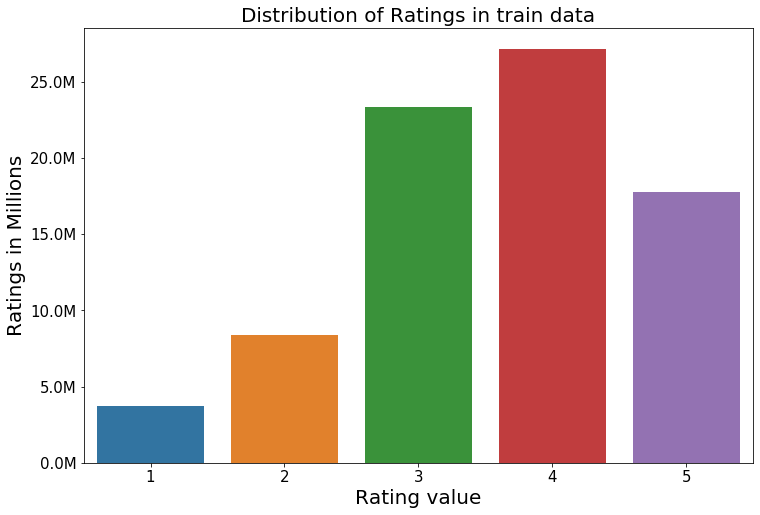

In [18]:
plt.figure(figsize = (12, 8))
ax = sns.countplot(x="Rating", data=X_train)
ax.set_yticklabels([Label(num) for num in ax.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Distribution of Ratings in train data", fontsize = 20)
plt.xlabel("Rating value", fontsize = 20)
plt.ylabel("Ratings in Millions", fontsize = 20)
plt.show()



In [19]:
X_train["DayOfWeek"] = X_train.Date.dt.day_name()

C:\Users\trama\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [20]:
X_train.tail()

,MID,CID,Rating,Date,DayOfWeek
65962842,12074,2033618,4,2005-08-08,Monday
4425817,862,1797061,3,2005-08-08,Monday
59747678,10986,1498715,5,2005-08-08,Monday
83182974,14861,500016,4,2005-08-08,Monday
32637774,5926,1044015,5,2005-08-08,Monday


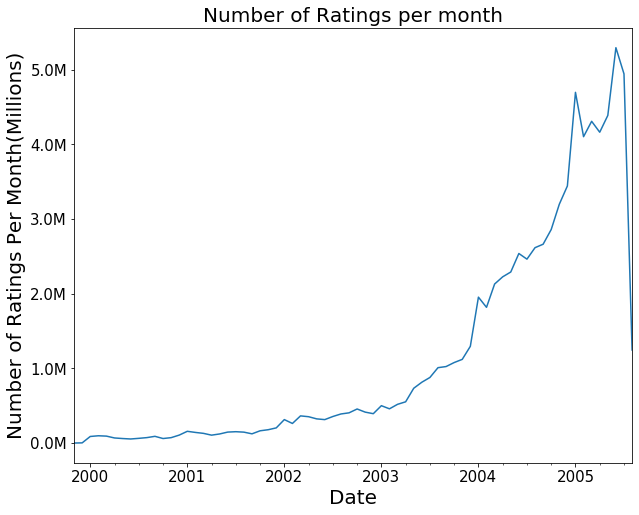

In [21]:
plt.figure(figsize = (10,8))
ax = X_train.resample("M", on = "Date")["Rating"].count().plot()

ax.set_yticklabels([Label(num) for num in ax.get_yticks()])
ax.set_title("Number of Ratings per month", fontsize = 20)
ax.set_xlabel("Date", fontsize = 20)
ax.set_ylabel("Number of Ratings Per Month(Millions)", fontsize = 20)
plt.tick_params(labelsize = 15)
plt.show()

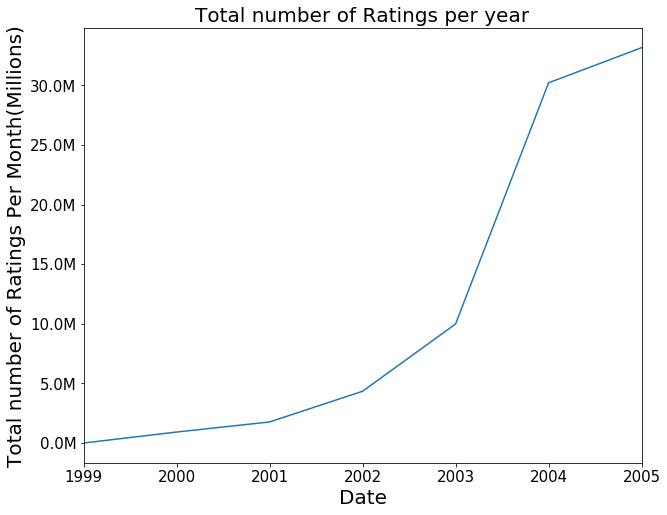

In [22]:
plt.figure(figsize = (10,8))
ax = X_train.resample("Y", on = "Date")["Rating"].count().plot()

ax.set_yticklabels([Label(num) for num in ax.get_yticks()])
ax.set_title("Total number of Ratings per year", fontsize = 20)
ax.set_xlabel("Date", fontsize = 20)
ax.set_ylabel("Total number of Ratings Per Month(Millions)", fontsize = 20)
plt.tick_params(labelsize = 15)
plt.show()

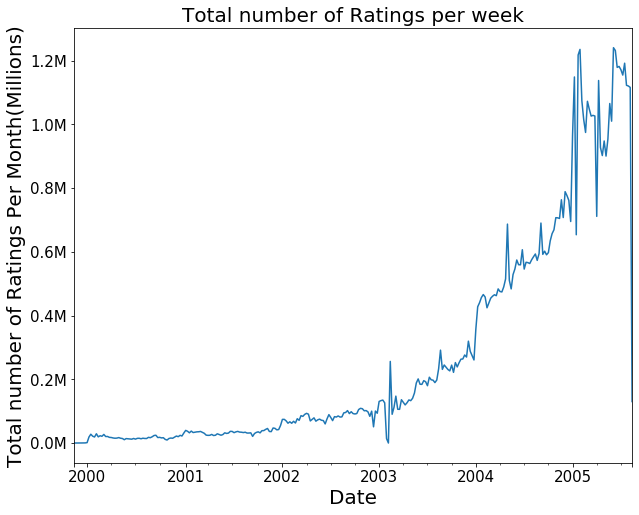

In [23]:
plt.figure(figsize = (10,8))
ax = X_train.resample("W", on = "Date")["Rating"].count().plot()

ax.set_yticklabels([Label(num) for num in ax.get_yticks()])
ax.set_title("Total number of Ratings per week", fontsize = 20)
ax.set_xlabel("Date", fontsize = 20)
ax.set_ylabel("Total number of Ratings Per Month(Millions)", fontsize = 20)
plt.tick_params(labelsize = 15)
plt.show()

In [24]:
no_of_rated_movies_per_user = X_train.groupby(by = "CID")["Rating"].count().sort_values(ascending = False)

In [25]:
no_of_rated_movies_per_user.head()

CID
305344     17112
2439493    15896
387418     15402
1639792     9767
1461435     9447
Name: Rating, dtype: int64

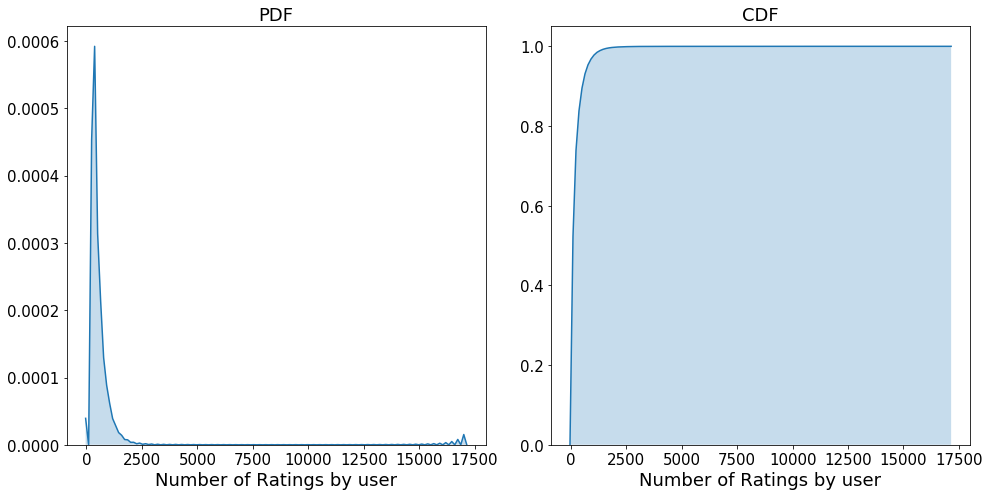

In [26]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(14,7))

sns.kdeplot(no_of_rated_movies_per_user.values, shade = True, ax = axes[0])
axes[0].set_title("PDF", fontsize = 18)
axes[0].set_xlabel("Number of Ratings by user", fontsize = 18)
axes[0].tick_params(labelsize = 15)

sns.kdeplot(no_of_rated_movies_per_user.values, shade = True, cumulative = True, ax = axes[1])
axes[1].set_title("CDF", fontsize = 18)
axes[1].set_xlabel("Number of Ratings by user", fontsize = 18)
axes[1].tick_params(labelsize = 15)

fig.subplots_adjust(wspace=2)
plt.tight_layout()
plt.show()

In [27]:
print("Information about movie ratings grouped by users:")
no_of_rated_movies_per_user.describe()

Information about movie ratings grouped by users:


count    405041.000000
mean        198.459921
std         290.793238
min           1.000000
25%          34.000000
50%          89.000000
75%         245.000000
max       17112.000000
Name: Rating, dtype: float64

In [28]:
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0,1.01,0.01))

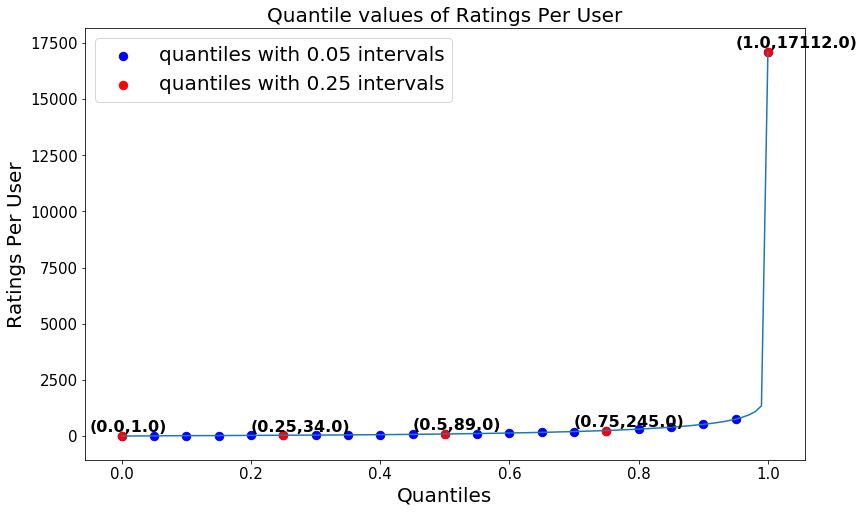

In [29]:
fig = plt.figure(figsize = (10, 6))

axes = fig.add_axes([0.1,0.1,1,1])
axes.set_title("Quantile values of Ratings Per User", fontsize = 20)
axes.set_xlabel("Quantiles", fontsize = 20)
axes.set_ylabel("Ratings Per User", fontsize = 20)
axes.plot(quantiles)

plt.scatter(x = quantiles.index[::5], y = quantiles.values[::5], c = "blue", s = 70, label="quantiles with 0.05 intervals")
plt.scatter(x = quantiles.index[::25], y = quantiles.values[::25], c = "red", s = 70, label="quantiles with 0.25 intervals")
plt.legend(loc='upper left', fontsize = 20)

for x, y in zip(quantiles.index[::25], quantiles.values[::25]):
    plt.annotate(s = '({},{})'.format(x, y), xy = (x, y), fontweight='bold', fontsize = 16, xytext=(x-0.05, y+180))
    
axes.tick_params(labelsize = 15)



In [30]:
quantiles[::5]

0.00        1.0
0.05        7.0
0.10       15.0
0.15       21.0
0.20       27.0
0.25       34.0
0.30       41.0
0.35       50.0
0.40       60.0
0.45       73.0
0.50       89.0
0.55      109.0
0.60      133.0
0.65      163.0
0.70      199.0
0.75      245.0
0.80      307.0
0.85      392.0
0.90      520.0
0.95      749.0
1.00    17112.0
Name: Rating, dtype: float64

In [31]:
print("Total number of ratings below 75th percentile = "+str(sum(no_of_rated_movies_per_user.values<=133)))
print("Total number of ratings above 75th percentile = "+str(sum(no_of_rated_movies_per_user.values>133)))

Total number of ratings below 75th percentile = 243251
Total number of ratings above 75th percentile = 161790


In [32]:
no_of_ratings_per_movie = X_train.groupby(by = "MID")["Rating"].count().sort_values(ascending = False)

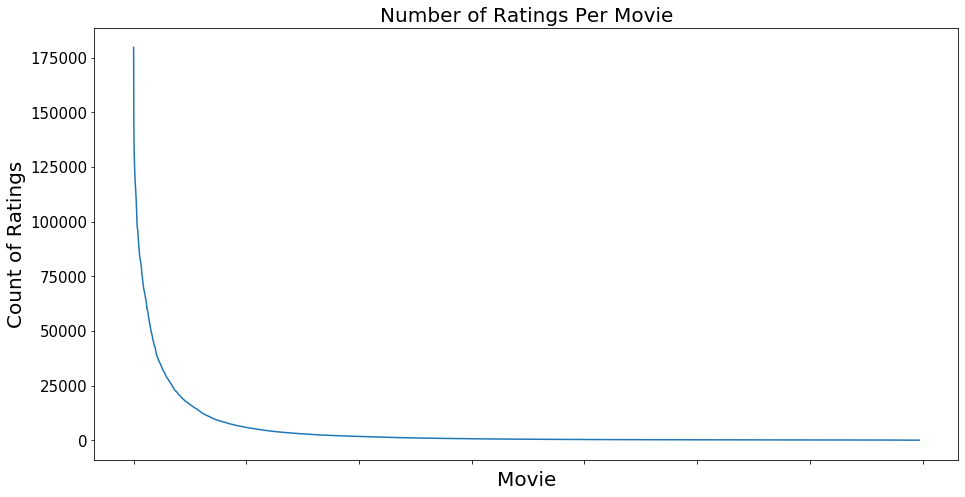

In [33]:
fig = plt.figure(figsize = (12, 6))
axes = fig.add_axes([0.1,0.1,1,1])
plt.title("Number of Ratings Per Movie", fontsize = 20)
plt.xlabel("Movie", fontsize = 20)
plt.ylabel("Count of Ratings", fontsize = 20)
plt.plot(no_of_ratings_per_movie.values)
plt.tick_params(labelsize = 15)
axes.set_xticklabels([])
plt.show()

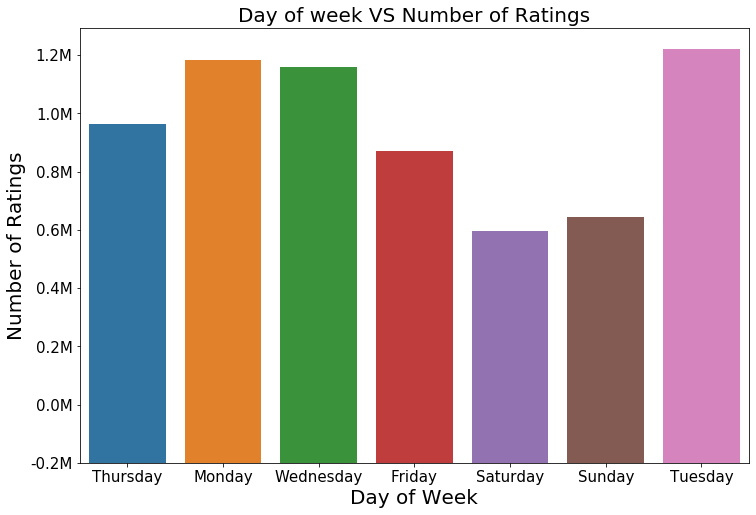

In [34]:
fig = plt.figure(figsize = (12, 8))

axes = sns.countplot(x = "DayOfWeek", data = X_train)
axes.set_title("Day of week VS Number of Ratings", fontsize = 20)
axes.set_xlabel("Day of Week", fontsize = 20)
axes.set_ylabel("Number of Ratings", fontsize = 20)
axes.set_yticklabels([Label(num) for num in ax.get_yticks()])
axes.tick_params(labelsize = 15)

plt.show()

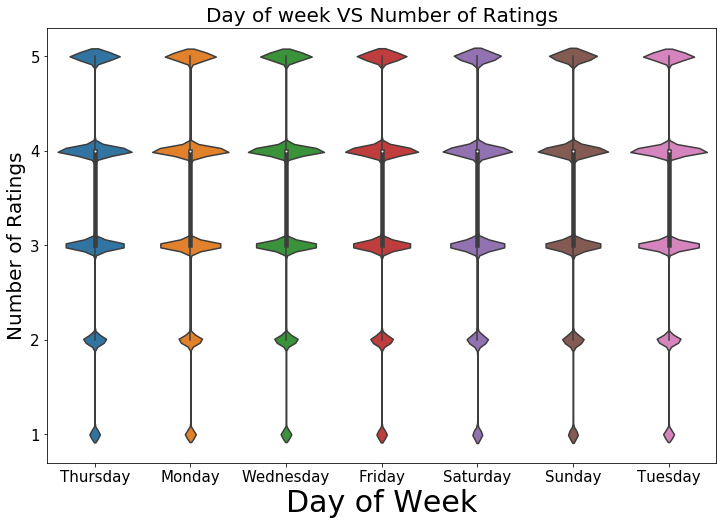

In [35]:
fig = plt.figure(figsize = (12, 8))

axes = sns.violinplot(x = "DayOfWeek", y = "Rating", data = X_train)
axes.set_title("Day of week VS Number of Ratings", fontsize = 20)
axes.set_xlabel("Day of Week", fontsize = 30)
axes.set_ylabel("Number of Ratings", fontsize = 20)
axes.tick_params(labelsize = 15)

plt.show()

#Generating Sparse Matrix


In [36]:
Sparse_TrainData = sparse.csr_matrix((X_train.Rating, (X_train.CID, X_train.MID)))

In [37]:
Sparse_TestData = sparse.csr_matrix((X_test.Rating, (X_test.CID, X_test.MID)))


In [38]:
len(X_train)

80384405

In [39]:
len(X_test)

20096102

In [40]:
def getAvgRatings(sparseMatrix,s):
    if s=='row':
      ax=1
    else:
      ax=0 
    Ratingssum = sparseMatrix.sum(axis = ax).A1  #this will give an array of sum of all the ratings of user if axis = 1 else 
    #sum of all the ratings of movies if axis = 0
    Ratingstotalnumber = (sparseMatrix!=0).sum(axis = ax).A1  
    #this will give a boolean True or False array, and True means 1 and False means 0
    #And further we are summing it to get the count of all the non-zero cells means length of non-zero cells
    rows, cols = sparseMatrix.shape
    avgRatings = {i: Ratingssum[i]/Ratingstotalnumber[i] for i in range(rows if s=='row' else cols) if Ratingstotalnumber[i]!=0}
    return avgRatings

#Get average ratings movie wise or user wise
## User wise data is stored in a column
## Movie wise data is stored in a row

In [41]:
AvgRatingUser = getAvgRatings(Sparse_TrainData, 'row')
AvgRatingMovie = getAvgRatings(Sparse_TrainData, 'column')

In [42]:
start = datetime.now()
movie_movie_similarity = cosine_similarity(Sparse_TrainData.T, dense_output = False)    
print(datetime.now() - start)

0:02:29.830527


In [43]:
movie_ids = np.unique(movie_movie_similarity.nonzero())

# For the top 100 movies we identify the movies most similar to them.
## Note: We can do this for all the movies in dataset but it takes more than 2 days to run the algorithm.  

In [44]:
similar_movies_dict = {}
for movie in movie_ids:
    smlr = np.argsort(-movie_movie_similarity[movie].toarray().ravel())[1:100]
    similar_movies_dict[movie] = smlr

In [45]:
movie_titles_df = pd.read_csv("archive/movie_titles.csv",sep = ",", header = None, names=['MID', 'Year_of_Release', 'Movie_Title'], index_col = "MID", encoding = "iso8859_2")

In [46]:
movie_titles_df.head()

,Year_of_Release,Movie_Title
MID,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


In [47]:
MID_GR = 1
#Trying to find similar movies to movie which has ID 1 using cosine similarity
print("Movie: "+str(movie_titles_df.loc[MID_GR][1]))

print("Ratings for {} :- {}".format(movie_titles_df.loc[MID_GR][1], Sparse_TrainData[:,MID_GR].getnnz()))

print("Total number of similar movies to {} is {}".format(movie_titles_df.loc[MID_GR][1], movie_movie_similarity[MID_GR].count_nonzero()))

Movie: Dinosaur Planet
Ratings for Dinosaur Planet :- 395
Total number of similar movies to Dinosaur Planet is 17297


In [48]:
movie_titles_df.iloc[395]

Year_of_Release                           2001
Movie_Title        Arjuna: Complete Collection
Name: 396, dtype: object

In [49]:
similar_movies_dict[MID_GR][:10]

array([  694,  5302,  1084, 13586,  1173,  4181,  8800, 10656, 15648,
       10257], dtype=int64)

In [50]:
def get_sample_sparse_matrix(sparse_matrix, no_users, no_movies, path, verbose = True):

    #sparse_matrix is used to obtained (row,col) and (rating) tuples
    index_row, index_column, ratings = sparse.find(sparse_matrix)
    users = np.unique(index_row)
    movies = np.unique(index_column)

    print("Original Matrix : (users, movies) -- ({} {})".format(len(users), len(movies)))
    print("Original Matrix : Ratings -- {}\n".format(len(ratings)))

    np.random.seed(15)
    user_sampleArr = np.random.choice(users, no_users, replace=False)
    movie_sampleArr = np.random.choice(movies, no_movies, replace=False)
    
    #We get the boolean mask or we could get the sampled_items in original row/column..
    mask = np.logical_and( np.isin(index_row, user_sampleArr),
                      np.isin(index_column, movie_sampleArr) )
    
    sample_sparse_matrix = sparse.csr_matrix((ratings[mask], (index_row[mask], index_column[mask])),
                                             shape=(max(user_sampleArr)+1, max(movie_sampleArr)+1))

    if verbose:
        print("Sampled Matrix : (users, movies) -> ({} {})".format(len(user_sampleArr), len(movie_sampleArr)))
        print("Sampled Matrix : Ratings ->", format(ratings[mask].shape[0]))

    #The data is save it into disk for further use to reduce time required for computation later
    sparse.save_npz(path, sample_sparse_matrix)
    if verbose:
            print('Completed\n')
    
    return sample_sparse_matrix

In [51]:
start = datetime.now()
path = "archive/sample_train_sparse_matrix.npz"
if os.path.isfile(path):
    print("File present in pwd")
    #It's obtained through the disk to save computing time
    sample_train_sparse_matrix = sparse.load_npz(path)
    print("Completed.")
else: 
    #get 6000 users and 600 movies from the data available  
    sample_train_sparse_matrix = get_sample_sparse_matrix(Sparse_TrainData, no_users=6000, no_movies=600,
                                             path = path)

print(datetime.now() - start)

File present in pwd
Completed.
0:00:00.052114


In [52]:
start = datetime.now()

path = "archive/sample_test_sparse_matrix.npz"
if os.path.isfile(path):
    print("File present in pwd")
    # just get it from the disk instead of computing it
    sample_test_sparse_matrix = sparse.load_npz(path)
    print("Completed.")
else:
    # get 3k users and 300 movies from available data 
    sample_test_sparse_matrix = get_sample_sparse_matrix(Sparse_TestData, no_users=3000, no_movies=300,
                                                 path = "sample_test_sparse_matrix.npz")
print(datetime.now() - start)

File present in pwd
Completed.
0:00:00.031019


In [53]:
sample_train_avg = dict()
global_avg = sample_train_sparse_matrix.sum()/sample_train_sparse_matrix.count_nonzero()
sample_train_avg['global'] = global_avg
sample_train_avg

{'global': 3.587763568709636}

In [55]:
sample_train_avg['user'] = getAvgRatings(sample_train_sparse_matrix, 'row')


In [56]:
sample_train_avg['movie'] =  getAvgRatings(sample_train_sparse_matrix, 'column')

In [57]:
print('No of ratings in Sample train matrix are : {}\n'.format(sample_train_sparse_matrix.count_nonzero()))
print('No of ratings in Sample test matrix are : {}\n'.format(sample_test_sparse_matrix.count_nonzero()))

No of ratings in Sample train matrix are : 46762

No of ratings in Sample test matrix are : 2829



In [58]:
sample_trainUsers, sample_trainMovies, sample_trainRatings = sparse.find(sample_train_sparse_matrix)

In [59]:
############################################################
# It took me almost 10 hours to prepare this train dataset.#
############################################################
start = datetime.now()
if os.path.isfile('archive/reg_train.csv'):
    print("File exists in directory" )
else:
    print('preparing {} tuples for the dataset.\n'.format(len(sample_trainRatings)))
    with open('archive/reg_train.csv', mode='w') as reg_data_file:
        count = 0
        for (user, movie, rating)  in zip(sample_trainUsers, sample_trainMovies, sample_trainRatings):
            st = datetime.now()
            #Finding the users similar to "user"        
            similar_users = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
            top_similar_users = similar_users.argsort()[::-1][1:] 
            #Ignoring 'user' from its similar users.
            #Getting the ratings of most similar users for this movie
            top_ratings = sample_train_sparse_matrix[top_similar_users, movie].toarray().ravel()
            #Making it's length "5" by adding movie averages .
            top_similar_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_similar_users_ratings.extend([sample_train_avg['movie'][movie]]*(5 - len(top_similar_users_ratings)))
            #Finding the movies similar to "movie"        
            movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
            top_similar_movies = movie_sim.argsort()[::-1][1:] 
            #Ignoring 'movie' from its similar movies.
            # get the ratings of most similar movie rated by this user..
            top_ratings = sample_train_sparse_matrix[user, top_similar_movies].toarray().ravel()
            #Making it's length "5" by adding user averages.
            top_similar_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_similar_movies_ratings.extend([sample_train_avg['user'][user]]*(5-len(top_similar_movies_ratings))) 
      
            row = []
            row.append(user)
            row.append(movie)
            
            #Adding other features to this data
            
            row.append(sample_train_avg['global']) 
            #This will be the first feature
            
            #Next 5 features are similar_users "movie" ratings
            row.extend(top_similar_users_ratings)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_similar_movies_ratings)
            # Avg_user rating
            row.append(sample_train_avg['user'][user])
            # Avg_movie rating
            row.append(sample_train_avg['movie'][movie])

            #Getting the actual rating of this particular user-movie combination
            row.append(rating)
            count = count + 1

            #Adding rows to the file opened
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%10000 == 0:
                print("Done for {} rows----- {}".format(count, datetime.now() - start))


print(datetime.now() - start)

File exists in directory
0:00:00.000989


In [60]:
reg_train = pd.read_csv('archive/reg_train.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating'], header=None)
reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,53406,33,3.587764,5.0,3.0,4.0,4.0,5.0,5.0,2.0,3.0,1.0,3.0,3.342857,4.119403,4
1,99865,33,3.587764,3.0,5.0,5.0,4.0,5.0,5.0,4.0,5.0,5.0,4.0,3.842105,4.119403,5
2,101620,33,3.587764,4.0,4.0,3.0,5.0,5.0,3.0,4.0,5.0,4.0,5.0,3.608696,4.119403,5
3,112974,33,3.587764,4.0,5.0,5.0,5.0,3.0,3.0,5.0,2.0,5.0,5.0,3.800000,4.119403,5
4,125275,33,3.587764,3.0,4.0,5.0,5.0,4.0,2.0,3.0,2.0,5.0,4.0,3.394737,4.119403,4


In [61]:
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(sample_test_sparse_matrix)

In [62]:
start = datetime.now()

if os.path.isfile('archive/reg_test.csv'):
    print("File is already created")
else:

    print('preparing {} tuples for the dataset..\n'.format(len(sample_test_ratings)))
    with open('archive/reg_test.csv', mode='w') as reg_data_file:
        count = 0 
        for (user, movie, rating)  in zip(sample_test_users, sample_test_movies, sample_test_ratings):
            st = datetime.now()
            try:
                #Carrying out similar operations as performed before
                similar_users = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
                top_similar_users = similar_users.argsort()[::-1][1:] 
                
                top_ratings = sample_train_sparse_matrix[top_similar_users, movie].toarray().ravel()
                
                top_similar_users_ratings = list(top_ratings[top_ratings != 0][:5])
                top_similar_users_ratings.extend([sample_train_avg['movie'][movie]]*(5 - len(top_similar_users_ratings)))
                
                
            except (IndexError, KeyError):
                # It is a new User or new Movie or there are no ratings for given user for top similar movies.
                top_similar_users_ratings.extend([sample_train_avg['global']]*(5 - len(top_similar_users_ratings)))
            except:
                print(user, movie)
                #Only solving KeyErrors and not every exception.
                raise



            #Ratings by "user"  to similar movies of "movie"
            try:
                  
                movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
                top_similar_movies = movie_sim.argsort()[::-1][1:] 
                
                top_ratings = sample_train_sparse_matrix[user, top_similar_movies].toarray().ravel()
               
                top_similar_movies_ratings = list(top_ratings[top_ratings != 0][:5])
                top_similar_movies_ratings.extend([sample_train_avg['user'][user]]*(5-len(top_similar_movies_ratings))) 
                
            except (IndexError, KeyError):
                
                top_similar_movies_ratings.extend([sample_train_avg['global']]*(5-len(top_similar_movies_ratings)))
                
            except :
                raise

            #Storing the rows in a file
            row = []
            #Adding user and movie name
            row.append(user)
            row.append(movie)
            row.append(sample_train_avg['global'])
            
            row.extend(top_similar_users_ratings)
            
            row.extend(top_similar_movies_ratings)
            
            try:
                row.append(sample_train_avg['user'][user])
            except KeyError:
                row.append(sample_train_avg['global'])
            except:
                raise

                
            try:
                row.append(sample_train_avg['movie'][movie])
            except KeyError:
                row.append(sample_train_avg['global'])
            except:
                raise
            
            #The actual Rating of this user-movie pair...
            row.append(rating)
            
            count = count + 1

            #Adding rows to the file
            reg_data_file.write(','.join(map(str, row)))
            
            reg_data_file.write('\n')        
            if (count)%1000 == 0:
            
                print("Done for {} rows----- {}".format(count, datetime.now() - start))
    print("",datetime.now() - start)

File is already created


In [63]:
reg_test_df = pd.read_csv('archive/reg_test.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
                                                          'smr1', 'smr2', 'smr3', 'smr4', 'smr5',
                                                          'UAvg', 'MAvg', 'rating'], header=None)
reg_test_df.head(4)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,808635,71,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,5
1,941866,71,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,4
2,1737912,71,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3
3,117617,111,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,4


In [64]:
reader = Reader(rating_scale=(1,5))

#Creating the traindata from the dataframe
train_data = Dataset.load_from_df(reg_train[['user', 'movie', 'rating']], reader)

#Building the trainset from traindata
trainset = train_data.build_full_trainset()

In [65]:
testset = list(zip(reg_test_df.user.values, reg_test_df.movie.values, reg_test_df.rating.values))
testset[:3]

[(808635, 71, 5), (941866, 71, 4), (1737912, 71, 3)]

In [66]:
models_evaluation_train = dict()
models_evaluation_test = dict()

models_evaluation_train, models_evaluation_test

({}, {})

In [67]:
#Calculating rmse and mape given actual and predicted ratings
def get_error_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
    mape = np.mean(np.abs( (y_true - y_pred)/y_true )) * 100
    return rmse, mape



def run_xgboost(algo,  x_train, y_train, x_test, y_test, verbose=True):

    train_results = {}
    test_results = {}
    
    
    #Fit the model
    print('Training the model.')
    start = datetime.now()
    algo.fit(x_train, y_train, eval_metric = 'rmse')
    print('Training completed. Time taken : {}\n'.format(datetime.now()-start))
    
    #Getting the predictions from the model
    print('Evaluating the model with TRAIN data.')
    start = datetime.now()
    y_train_prediction = algo.predict(x_train)
    #Getting the rmse and mape of train data
    rmse_train, mape_train = get_error_metrics(y_train.values, y_train_prediction)
    
    #Storing the results in train_results
    train_results = {'rmse': rmse_train,
                    'mape' : mape_train,
                    'predictions' : y_train_prediction}
    

    print('Evaluating Test data')
    y_test_pred = algo.predict(x_test) 
    rmse_test, mape_test = get_error_metrics(y_true=y_test.values, y_pred=y_test_pred)
    # store them in our test results
    test_results = {'rmse': rmse_test,
                    'mape' : mape_test,
                    'predictions':y_test_pred}
    if verbose:
        print('\nTEST DATA')
        print('-'*30)
        print('RMSE : ', rmse_test)
        print('MAPE : ', mape_test)
        
    #Returning train and test results
    return train_results, test_results

In [68]:
random.seed(15)
np.random.seed(15)


#Obtaining the actual_list and predicted_list ratings
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])
    
    return actual, pred


#Obtaining RMSE and MAPE

def get_errors(predictions, print_them=False):

    actual, pred = get_ratings(predictions)
    rmse = np.sqrt(np.mean((pred - actual)**2))
    mape = np.mean(np.abs(pred - actual)/actual)

    return rmse, mape*100

#It will return predicted ratings, rmse and mape of both training and testing datasets

def run_surprise(algo, trainset, testset, verbose=True): 
    
    start = datetime.now()
    train = {}
    test = {}
    
    #Training the algorithm with trainset
    st = datetime.now()
    print('Training the model')
    algo.fit(trainset)
    print('Training Completed, time taken : {} \n'.format(datetime.now()-st))
    
    #Evaluating train data
    start = datetime.now()
    print('Evaluating the model with train data')
    
    train_predictions = algo.test(trainset.build_testset())
    
    train_actual_ratings, train_prediction_ratings = get_ratings(train_predictions)
    
    train_rmse, train_mape = get_errors(train_predictions)
    print('time taken : {}'.format(datetime.now()-start))
    
    if verbose:
        print('-'*15)
        print('Train Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(train_rmse, train_mape))
    
    #Storing them in 'train'
    if verbose:
        train['rmse'] = train_rmse
        train['mape'] = train_mape
        train['predictions'] = train_prediction_ratings

    #Evaluating Test data
    start = datetime.now()
    print('Evaluating for test dataset')
    #Get the predictions of test data
    test_preds = algo.test(testset)
    #Get the predicted ratings from the list of predictions
    test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
    #Get error metrics from the predicted and actual ratings
    test_rmse, test_mape = get_errors(test_preds)
    print('time taken : {}'.format(datetime.now()-start))
    
    if verbose:
        print('-'*15)
        print('Test Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(test_rmse, test_mape))
    # store them in test dictionary
    if verbose:
        print('storing the test results in test dictionary...')
    test['rmse'] = test_rmse
    test['mape'] = test_mape
    test['predictions'] = test_pred_ratings
    
    print('\n'+'-'*45)
    print('Total time taken to run this algorithm :', datetime.now() - start)
    
    # return two dictionaries train and test
    return train, test

In [69]:
#4.4.1 XGBoost with initial 13 features

Training the model.
[02:11:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Training completed. Time taken : 0:00:01.619222

Evaluating the model with TRAIN data.
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0983414903969977
MAPE :  34.6066920514577


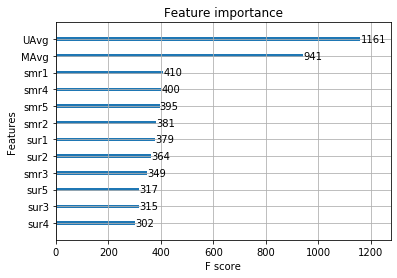

In [70]:
# prepare Train data
x_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# initialize Our first XGBoost model...
first_xgb = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=100)
train_results, test_results = run_xgboost(first_xgb, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['XGB'] = train_results
models_evaluation_test['XGB'] = test_results

xgb.plot_importance(first_xgb)
plt.show()

In [71]:
#4.4.2 Suprise BaselineModel

In [72]:
# options are to specify.., how to compute those user and item biases
bsl_options = {'method': 'sgd',
               'learning_rate': .001
               }
bsl_algo = BaselineOnly(bsl_options=bsl_options)
# run this algorithm.., It will return the train and test results..
bsl_train_results, bsl_test_results = run_surprise(bsl_algo, trainset, testset, verbose=True)


# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['bsl_algo'] = bsl_train_results 
models_evaluation_test['bsl_algo'] = bsl_test_results

Training the model
Estimating biases using sgd...
Training Completed, time taken : 0:00:00.202458 

Evaluating the model with train data
time taken : 0:00:00.338777
---------------
Train Data
---------------
RMSE : 0.9510202022117997

MAPE : 30.090540953428242

Evaluating for test dataset
time taken : 0:00:00.020943
---------------
Test Data
---------------
RMSE : 1.0829335919531395

MAPE : 36.4621422879574

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:00.020943


In [73]:
#4.4.3 XGBoost with initial 13 features + Surprise Baseline predictor

In [74]:
#Updating Train Data

In [75]:
# add our baseline_predicted value as our feature..
reg_train['bslpr'] = models_evaluation_train['bsl_algo']['predictions']
reg_train.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,53406,33,3.587764,5.0,3.0,4.0,4.0,5.0,5.0,2.0,3.0,1.0,3.0,3.342857,4.119403,4,3.846983
1,99865,33,3.587764,3.0,5.0,5.0,4.0,5.0,5.0,4.0,5.0,5.0,4.0,3.842105,4.119403,5,3.374390


In [76]:
#Updating Test Data

In [77]:
# add that baseline predicted ratings with Surprise to the test data as well
reg_test_df['bslpr']  = models_evaluation_test['bsl_algo']['predictions']

reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,808635,71,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,5,3.587764
1,941866,71,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,4,3.587764


Training the model.
[02:11:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Training completed. Time taken : 0:00:02.313809

Evaluating the model with TRAIN data.
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.127705579406932
MAPE :  33.56068159478481


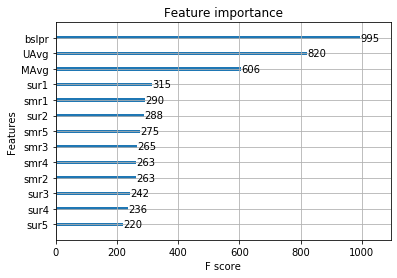

In [78]:
# prepare train data
x_train = reg_train.drop(['user', 'movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# initialize Our first XGBoost model...
xgb_bsl = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=100)
train_results, test_results = run_xgboost(xgb_bsl, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_bsl'] = train_results
models_evaluation_test['xgb_bsl'] = test_results

xgb.plot_importance(xgb_bsl)
plt.show()

In [79]:
#4.4.4 Surprise SlopeOne predictor

In [80]:
# we specify , how to compute similarities and what to consider with sim_options to our algorithm

slpOne_bsl = SlopeOne()
slpOne_bsl_train_results, slpOne_bsl_test_results = run_surprise(slpOne_bsl, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['slpOne_bsl'] = slpOne_bsl_train_results 
models_evaluation_test['slpOne_bsl'] = slpOne_bsl_test_results

Training the model
Training Completed, time taken : 0:00:00.080392 

Evaluating the model with train data
time taken : 0:00:00.864862
---------------
Train Data
---------------
RMSE : 0.8050724462176874

MAPE : 23.547939022142387

Evaluating for test dataset
time taken : 0:00:00.024360
---------------
Test Data
---------------
RMSE : 1.0852024439055872

MAPE : 36.584963942219105

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:00.024360


In [81]:
#4.4.4.2 Surprise CoClustering predictor

In [82]:
# we specify , how to compute similarities and what to consider with sim_options to our algorithm

cC_bsl = CoClustering()
cC_bsl_train_results, cC_bsl_test_results = run_surprise(cC_bsl, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['cC_bsl'] = cC_bsl_train_results 
models_evaluation_test['cC_bsl'] = cC_bsl_test_results

Training the model
Training Completed, time taken : 0:00:01.171053 

Evaluating the model with train data
time taken : 0:00:00.318209
---------------
Train Data
---------------
RMSE : 0.8271595113395926

MAPE : 23.967280254188957

Evaluating for test dataset
time taken : 0:00:00.024933
---------------
Test Data
---------------
RMSE : 1.0853023145214524

MAPE : 36.5847967119654

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:00.024933


In [83]:
#Preparing Train data

In [84]:
# add the predicted values from both knns to this dataframe
reg_train['slpOne_bsl'] = models_evaluation_train['slpOne_bsl']['predictions']

reg_train.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,slpOne_bsl
0,53406,33,3.587764,5.0,3.0,4.0,4.0,5.0,5.0,2.0,3.0,1.0,3.0,3.342857,4.119403,4,3.846983,3.884264
1,99865,33,3.587764,3.0,5.0,5.0,4.0,5.0,5.0,4.0,5.0,5.0,4.0,3.842105,4.119403,5,3.374390,3.438223


In [85]:
reg_test_df['slpOne_bsl'] = models_evaluation_test['slpOne_bsl']['predictions']

reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,slpOne_bsl
0,808635,71,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,5,3.587764,3.587764
1,941866,71,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,4,3.587764,3.587764


Training the model.
Training completed. Time taken : 0:00:02.101377

Evaluating the model with TRAIN data.
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0883343056251564
MAPE :  35.173606053249316


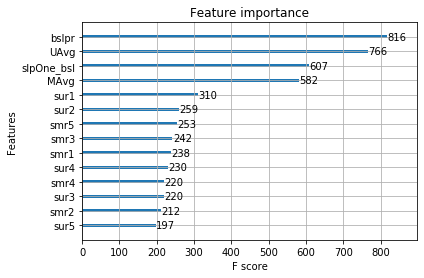

In [86]:
# prepare the train data....
x_train = reg_train.drop(['user', 'movie', 'rating'], axis=1)
y_train = reg_train['rating']

# prepare the train data....
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# declare the model
xgb_knn_bsl = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_knn_bsl, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_slpOne_bsl'] = train_results
models_evaluation_test['xgb_slpOne_bsl'] = test_results


xgb.plot_importance(xgb_knn_bsl)
plt.show()

In [87]:
# add the predicted values from both knns to this dataframe
reg_train['cC_bsl'] = models_evaluation_train['cC_bsl']['predictions']

reg_train.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,slpOne_bsl,cC_bsl
0,53406,33,3.587764,5.0,3.0,4.0,4.0,5.0,5.0,2.0,3.0,1.0,3.0,3.342857,4.119403,4,3.846983,3.884264,3.540432
1,99865,33,3.587764,3.0,5.0,5.0,4.0,5.0,5.0,4.0,5.0,5.0,4.0,3.842105,4.119403,5,3.374390,3.438223,3.164940


In [88]:

reg_test_df['cC_bsl'] = models_evaluation_test['cC_bsl']['predictions']

reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,slpOne_bsl,cC_bsl
0,808635,71,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,5,3.587764,3.587764,3.587764
1,941866,71,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,4,3.587764,3.587764,3.587764


Training the model.
Training completed. Time taken : 0:00:02.234987

Evaluating the model with TRAIN data.
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.1308185696539528
MAPE :  33.46595067150309


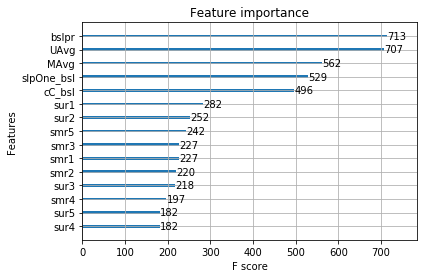

In [89]:
# prepare the train data....
x_train = reg_train.drop(['user', 'movie', 'rating'], axis=1)
y_train = reg_train['rating']

# prepare the train data....
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# declare the model
xgb_knn_bsl = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_knn_bsl, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_cC_bsl'] = train_results
models_evaluation_test['xgb_cC_bsl'] = test_results


xgb.plot_importance(xgb_knn_bsl)
plt.show()

In [90]:
#4.4.6 Matrix Factorization Techniques

In [91]:
#4.4.6.1 SVD Matrix Factorization User Movie intractions

In [92]:
# initiallize the model
svd = SVD(n_factors=100, biased=True, random_state=15, verbose=True)
svd_train_results, svd_test_results = run_surprise(svd, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation data structure
models_evaluation_train['svd'] = svd_train_results 
models_evaluation_test['svd'] = svd_test_results

Training the model
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Training Completed, time taken : 0:00:02.311816 

Evaluating the model with train data
time taken : 0:00:00.353090
---------------
Train Data
---------------
RMSE : 0.6489101978148224

MAPE : 19.610682031594102

Evaluating for test dataset
time taken : 0:00:00.023902
---------------
Test Data
---------------
RMSE : 1.0824414317932143

MAPE : 36.42986808992713

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:00.023902


Training the model.
Training completed. Time taken : 0:00:02.247985

Evaluating the model with TRAIN data.
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.1308185696539528
MAPE :  33.46595067150309


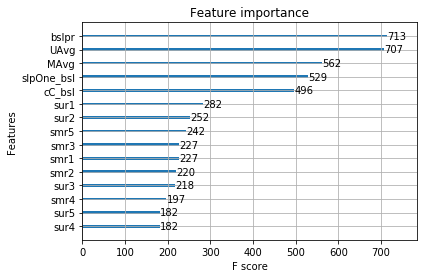

In [93]:
# prepare the train data....
x_train = reg_train.drop(['user', 'movie', 'rating'], axis=1)
y_train = reg_train['rating']

# prepare the train data....
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# declare the model
xgb_knn_bsl = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_knn_bsl, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_svd'] = train_results
models_evaluation_test['xgb_svd'] = test_results


xgb.plot_importance(xgb_knn_bsl)
plt.show()

In [94]:
# initiallize the model
svdpp = SVDpp(n_factors=50, random_state=15, verbose=True)
svdpp_train_results, svdpp_test_results = run_surprise(svdpp, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svdpp'] = svdpp_train_results 
models_evaluation_test['svdpp'] = svdpp_test_results

Training the model
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
Training Completed, time taken : 0:00:22.445503 

Evaluating the model with train data
time taken : 0:00:01.300735
---------------
Train Data
---------------
RMSE : 0.580922953588603

MAPE : 16.906180713949645

Evaluating for test dataset
time taken : 0:00:00.020944
---------------
Test Data
---------------
RMSE : 1.0827172882861422

MAPE : 36.44401463411591

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:00.020944


Training the model.
Training completed. Time taken : 0:00:02.236019

Evaluating the model with TRAIN data.
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.1308185696539528
MAPE :  33.46595067150309


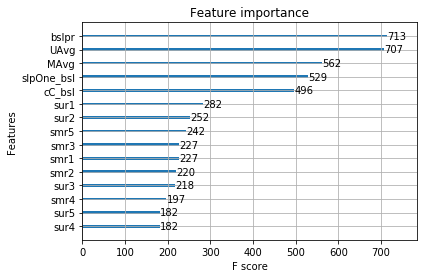

In [95]:
# prepare the train data....
x_train = reg_train.drop(['user', 'movie', 'rating'], axis=1)
y_train = reg_train['rating']

# prepare the train data....
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# declare the model
xgb_knn_bsl = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_knn_bsl, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_svdpp'] = train_results
models_evaluation_test['xgb_svdpp'] = test_results


xgb.plot_importance(xgb_knn_bsl)
plt.show()

In [96]:
#4.4.7 XgBoost with 13 features + Surprise Baseline + Surprise KNNbaseline + MF Techniques

In [97]:
# add the predicted values from both knns to this dataframe
reg_train['svd'] = models_evaluation_train['svd']['predictions']
reg_train['svdpp'] = models_evaluation_train['svdpp']['predictions']

reg_train.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,slpOne_bsl,cC_bsl,svd,svdpp
0,53406,33,3.587764,5.0,3.0,4.0,4.0,5.0,5.0,2.0,...,1.0,3.0,3.342857,4.119403,4,3.846983,3.884264,3.540432,4.037523,3.987180
1,99865,33,3.587764,3.0,5.0,5.0,4.0,5.0,5.0,4.0,...,5.0,4.0,3.842105,4.119403,5,3.374390,3.438223,3.164940,3.065703,3.331309


In [98]:
reg_test_df['svd'] = models_evaluation_test['svd']['predictions']
reg_test_df['svdpp'] = models_evaluation_test['svdpp']['predictions']

reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,slpOne_bsl,cC_bsl,svd,svdpp
0,808635,71,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,...,3.587764,3.587764,3.587764,3.587764,5,3.587764,3.587764,3.587764,3.587764,3.587764
1,941866,71,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,3.587764,...,3.587764,3.587764,3.587764,3.587764,4,3.587764,3.587764,3.587764,3.587764,3.587764


Training the model.
Training completed. Time taken : 0:00:02.223053

Evaluating the model with TRAIN data.
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.1068606981868563
MAPE :  34.23381738434049


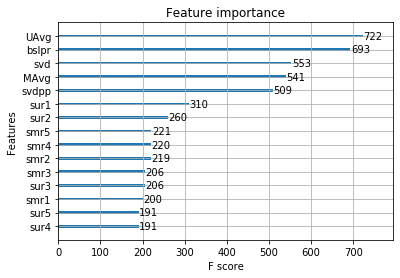

In [99]:
# prepare x_train and y_train
x_train = reg_train.drop(['user', 'movie', 'rating', 'cC_bsl','slpOne_bsl'], axis=1)
y_train = reg_train['rating']

# prepare test data
x_test = reg_test_df.drop(['user', 'movie', 'rating', 'cC_bsl','slpOne_bsl'], axis=1)
y_test = reg_test_df['rating']



xgb_final = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_final, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_final'] = train_results
models_evaluation_test['xgb_final'] = test_results


xgb.plot_importance(xgb_final)
plt.show()

In [100]:

#4.4.8 XgBoost with Surprise Baseline + Surprise KNNbaseline + MF Techniques

Training the model.
Training completed. Time taken : 0:00:01.951779

Evaluating the model with TRAIN data.
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0839702832528413
MAPE :  36.43785838793146


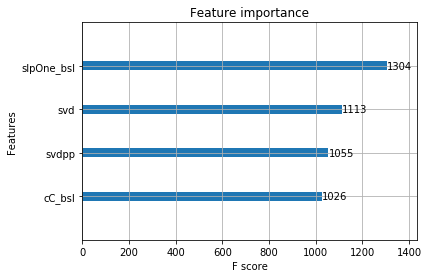

In [101]:
# prepare train data
x_train = reg_train[['slpOne_bsl', 'cC_bsl', 'svd', 'svdpp']]
y_train = reg_train['rating']

# test data
x_test = reg_test_df[['slpOne_bsl', 'cC_bsl', 'svd', 'svdpp']]
y_test = reg_test_df['rating']


xgb_all_models = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_all_models, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_all_models'] = train_results
models_evaluation_test['xgb_all_models'] = test_results

xgb.plot_importance(xgb_all_models)
plt.show()

In [102]:
#4.5 Comparision between all models

In [103]:
# Saving our TEST_RESULTS into a dataframe so that you don't have to run it again
pd.DataFrame(models_evaluation_test).to_csv('archive/small_sample_results.csv')
models = pd.read_csv('archive/small_sample_results.csv', index_col=0)
models.loc['rmse'].sort_values()

svd               1.0824414317932143
svdpp             1.0827172882861422
bsl_algo          1.0829335919531395
xgb_all_models    1.0839702832528413
slpOne_bsl        1.0852024439055872
cC_bsl            1.0853023145214524
xgb_slpOne_bsl    1.0883343056251564
XGB               1.0983414903969977
xgb_final         1.1068606981868563
xgb_bsl            1.127705579406932
xgb_cC_bsl        1.1308185696539528
xgb_svd           1.1308185696539528
xgb_svdpp         1.1308185696539528
Name: rmse, dtype: object